<a href="https://colab.research.google.com/github/poliduckie/poliduckie_pipeline/blob/master/notebooks/poliduckie_mpc_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PoliDuckies
A notebook with the complete pipeline

### Standard imports

In [ ]:
import os 
branch = "master" #@param ['master', 'daffy']
if branch == "daffy":
  !pip install duckietown-gym-daffy
else:
  if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
    !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
    !pip3 install -e gym-duckietown
  if "/gym-duckietown" not in os.getcwd():
    os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.14

from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown

# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

!pip install poliduckie-segmentation

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.6).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install poliduckie-segmentation==0.1.16

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
map_name = "Duckietown-small_loop-v0"

### Methods

In [ ]:
from poliduckie_segmentation.segmentation import Segmentation
def segmentation(image):
  """
    Returns the image from the simulation with the segmentation

    Image: np.Array
    ------
    Image: np.Array
  """
  resized = cv2.resize(image, (320, 240))
  seg = Segmentation()
  return seg.predict(resized)

In [ ]:
from poliduckie_segmentation.line_extraction import LineExtraction
def lineExtraction(image, n_points=100, mode="bezier", bezier_degree=3):
  """
    Returns the central line extracted as a numpy array. The mode can be either "bezier" or "spline"

    Image: np.Array
    n_points: int
    mode: str
    bezier_degree: int
    ------
    Line: np.Array
  """
  lineExtraction_ = LineExtraction()
  x, y, pca = lineExtraction_.extract_centroids(image)

  if mode == "bezier":
    bezier_points = lineExtraction_.bezier_fit(x, y)
    return bezier_points
  
  elif mode == "spline":
    spline_points = lineExtraction_.spline_interpolation(image, n_points=n_points)
    return spline_points

In [ ]:
def computeReference(line, N):
  """
    Returns the references in meters
    Reference is a list with dimension (2, N)
    N is the prediction horizon of the MPC

    Line: np.Array
    N: int
    ------
    reference: List[[List[Float], List[Float]]]
  """
  # extract x, y of reference
  # TODO

  reference = [[x]*N, [y]*N]
  pass

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from poliduckie_segmentation.control import MPC
M = MPC()

def runMpc(state, reference):
  """
    Returns the control inputs to give to the car.
    State is [x, y, theta, v, w]
    Reference is a list with dimension (2, N)

    state: [Float, Float, Float, Float, Float]
    reference: List[[List[Float], List[Float]]]
    ------
    u: List[Float, Float]
  """
  return M.mpc(state, reference)

In [ ]:
from google.colab.patches import cv2_imshow

### Simulation

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name)
env.reset()

/usr/local/lib/python3.9/dist-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to u

array([[[152, 174,  73],
        [152, 174,  73],
        [152, 174,  73],
        ...,
        [152, 174,  73],
        [152, 174,  73],
        [152, 174,  73]],

       [[152, 174,  73],
        [152, 174,  73],
        [152, 174,  73],
        ...,
        [152, 174,  73],
        [152, 174,  73],
        [152, 174,  73]],

       [[152, 174,  73],
        [152, 174,  73],
        [152, 174,  73],
        ...,
        [152, 174,  73],
        [152, 174,  73],
        [152, 174,  73]],

       ...,

       [[ 41,  40,  31],
        [ 41,  40,  30],
        [ 40,  40,  30],
        ...,
        [ 55,  56,  43],
        [ 54,  56,  42],
        [ 55,  57,  43]],

       [[ 43,  44,  33],
        [ 44,  44,  33],
        [ 44,  44,  33],
        ...,
        [ 52,  53,  40],
        [ 52,  53,  40],
        [ 52,  53,  40]],

       [[ 46,  46,  36],
        [ 46,  46,  36],
        [ 45,  46,  35],
        ...,
        [ 49,  50,  37],
        [ 49,  50,  37],
        [ 50,  51,  37]]

/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


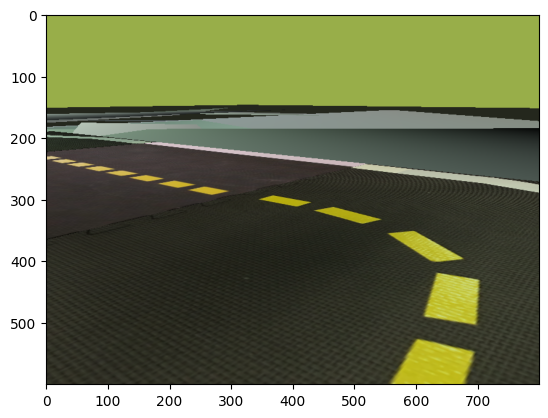

(600, 800, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                

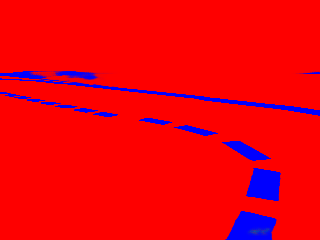

IndexError: ignored

In [ ]:
from poliduckie_segmentation.model import Model

# State X = [x, y, angle, longitudinal speed, angular speed]
state = [0,0,0,0,0]

F = Model()

image_recording = []

for _ in range(100):
  image = env.render(mode="rgb_array")
  plt.imshow(image)
  plt.show()
  print(image.shape)
  image_recording.append(image)
  image_segmentation = segmentation(image)[0]*255
  print(image_segmentation)
  cv2_imshow(image_segmentation)
  image_segmentation = image_segmentation[:, :, 0]
  cv2_imshow(image_segmentation)
  line = lineExtraction(image_segmentation)
  reference = computeReference(line)
  action = runMpc(state, reference)
  state = F.step(*state, action)
  env.step(action)